In [1]:
from typing import Any, Dict, Iterable, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

Reference notebook: [Survival Analysis for Deep Learning](https://colab.research.google.com/github/sebp/survival-cnn-estimator/blob/master/tutorial_tf2.ipynb).

# Generate data

In [2]:
N_COVAR = 128

In [3]:
def gen_data(
  n: int,
  base_rate=0.50,
  cens_prop=0.20,
  n_covar=N_COVAR,
) -> Dict[str, np.ndarray]:
  """Generate data.
  
  Args:
    n: Sample size.
    base_rate: Base event rate.
    cens_prop: Expected censoring proportion.
    n_covar: Number of covariates.
    n_freq: Number of frequencies.
  
  """

  # Covariates.
  x = np.random.rand(n, n_covar)
  
  # Linear predictor.
  coef = np.random.randn(n_covar)
  eta = np.dot(x, coef)
  eta = (eta - np.mean(eta)) / np.std(eta)

  # Time-to-event.
  event_rate = base_rate * np.exp(eta)
  event_time = np.random.exponential(scale=1/event_rate, size=len(event_rate))

  cens_rate = cens_prop / (1 - cens_prop) * event_rate 
  cens_time = np.random.exponential(scale=1/cens_rate, size=len(cens_rate))

  status = (event_time <= cens_time)
  time = np.where(status, event_time, cens_time)

  # Output.
  return {
    "x": x,
    "risk": event_rate,
    "status": status,
    "time": time,
  }

In [4]:
def split_data(
  data: Dict[str, np.ndarray],
  train_prop: float = 0.8,
) -> Dict[str, np.ndarray]:

  n = len(data["time"])
  n_train = int(train_prop * n)

  out = {}
  for key in data.keys():
    out[f"train_{key}"] = data[key][:n_train]
    out[f"val_{key}"] = data[key][n_train:]
  
  return out

# Kaplan-Meier

## Build masks

In [5]:
def build_masks(status: np.ndarray, time: np.ndarray) -> Tuple[np.ndarray]:
  """Build masks.

  Create unique-time (row) by subject (col) boolean masks.

  Returns:
    at_risk: [t, i] = True if subject i is at risk at time t.
    cens: [t, i] = True if subject is is censored at time t.
    event: [t, i] = True if subject i has an event at time t.
    unique_times: Unique times corresponding to the rows.

  """
  n_subj = len(time)

  # Add 0 if not present.
  unique_times = np.sort(np.unique(time))
  if not (0 in unique_times):
    unique_times = np.insert(unique_times, 0, 0)
  n_unique_time = len(unique_times)

  # Masks.
  at_risk = np.zeros(shape=(n_unique_time, n_subj), dtype=bool)
  cens = np.zeros(shape=(n_unique_time, n_subj), dtype=bool)
  event = np.zeros(shape=(n_unique_time, n_subj), dtype=bool)

  for i in range(n_subj):
    at_risk[:, i] = (time[i] >= unique_times)
    which_time = (unique_times == time[i])
    cens[:, i] = (not status[i]) * which_time
    event[:, i] = status[i] * which_time

  return at_risk, cens, event, unique_times

In [6]:
n = 5
status = np.array(np.round(np.random.rand(n)), dtype=bool)
time = np.arange(n, dtype=float)

In [7]:
print("Status:")
print(status)
print("\n")
print("Time:")
print(time)

Status:
[ True  True  True False  True]


Time:
[0. 1. 2. 3. 4.]


In [8]:
at_risk, cens, event, unique_times = build_masks(status, time)

In [9]:
print("At risk:")
print(at_risk)

At risk:
[[ True  True  True  True  True]
 [False  True  True  True  True]
 [False False  True  True  True]
 [False False False  True  True]
 [False False False False  True]]


In [10]:
print("Censored:")
print(cens)

Censored:
[[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False  True False]
 [False False False False False]]


In [11]:
print("Event:")
print(event)

Event:
[[ True False False False False]
 [False  True False False False]
 [False False  True False False]
 [False False False False False]
 [False False False False  True]]


## Tabulate KM

In [12]:
def tab_km(status: np.ndarray, time: np.ndarray) -> pd.DataFrame:
  """Taublate Kaplan-Meier."""
  at_risk, cens, event, unique_times = build_masks(status, time)

  out = pd.DataFrame({
    "time": unique_times,
    "n_at_risk": np.sum(at_risk, axis=1),
    "n_event": np.sum(event, axis=1),
    "n_cens": np.sum(cens, axis=1),
  })
  out["haz"] = out.n_event / out.n_at_risk
  out["surv"] = np.cumprod(1 - out.haz)
  return out  

## Estimator

In [13]:
class KaplanMeier:

  def __init__(self, status: np.ndarray, time: np.ndarray) -> None:
    self.status = status
    self.time = time
    self.km = tab_km(self.status, self.time)
  
  def return_table(self) -> pd.DataFrame:
    return self.km
    
  def __call__(self, x: float) -> float:
    km = self.km
    return km.surv[np.max(np.where(km.time <= x))]

In [14]:
# Fit Kaplan-Meier.
km = KaplanMeier(
  status = np.array([True, False, True, False]),
  time = np.arange(1, 5)
)
km.return_table()

,time,n_at_risk,n_event,n_cens,haz,surv
0,0,4,0,0,0.00,1.000
1,1,4,1,0,0.25,0.750
2,2,3,0,1,0.00,0.750
3,3,2,1,0,0.50,0.375
4,4,1,0,1,0.00,0.375


In [15]:
# Evaluate Kaplan-Meier.
km(1.1)

0.75

# C-statistic

* Reference: [On the C-statistics for Evaluating Overall Adequacy of Risk Prediction Procedures with Censored Survival Data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3079915/).

In [16]:
class Concord:
  """Calculate concordance.
  
  Note that the Kaplan-Meier curve of the censoring distribution may be fit
  using different data from that used to calculate the C-statistic.
  
  """

  def __init__(self, status: np.ndarray, time: np.ndarray) -> None:
    self.km = KaplanMeier(~status, time)
  
  def __call__(
    self,
    risk: np.ndarray,
    status: np.ndarray,
    time: np.ndarray,
    tau=None
  ) -> float:

    n = len(risk)
    upper = 0
    lower = 0

    if not tau:
      tau = np.max(time)

    for i in range(n):
      di, ti, ri = status[i], time[i], risk[i]

      # Only cases contribute.
      if not di:
        continue

      for j in range(n):
        tj, rj = time[j], risk[j]
        denom = di * (ti < tj) * (ti < tau)

        # Only calculate censoring weights if denom is non-zero.
        if denom:
          p_cens = np.squeeze(self.km(ti))
          weight = 1 / (p_cens ** 2)
          upper += denom * weight * (ri > rj)
          lower += denom * weight

    return upper / lower if lower > 0 else 0.5

# Proportional hazards loss

In [17]:
class CoxLoss(tf.keras.losses.Loss):

  def __init__(self, **kwargs):
    super().__init__(**kwargs) 
  
  def call(
      self,
      y_true: Tuple[tf.Tensor],
      y_pred: tf.Tensor
  ) -> tf.Tensor:
    """Calculate Cox PH Loss.
    
    Args:
      y_true: (at_risk, status).
      y_pred: risk.

    """
    
    # Note: autograph requires unpacking using indices.
    at_risk = y_true[0]
    status = y_true[1]
    risk_score = tf.squeeze(y_pred)

    risk_score_mat = tf.math.multiply(
        tf.ones_like(at_risk, dtype=risk_score.dtype), risk_score)
    
    # Only at-risk subjects contribute to the denominator.
    denom = tf.reduce_logsumexp(
        tf.ragged.boolean_mask(risk_score_mat, at_risk), axis=-1)
  
    diff = tf.subtract(risk_score, denom)

    # The log-likelihood only increments at event times.
    return -1 * tf.reduce_mean(tf.ragged.boolean_mask(diff, status))

## Testing

In [18]:
def logsumexp(x: np.ndarray) -> np.ndarray:
  delta = np.max(x)
  y = x - delta
  return delta + np.log(np.sum(np.exp(y)))

In [19]:
time = tf.constant(np.array([1, 2, 3]), dtype=tf.float32)
status = tf.constant(np.array([True, False, True]), dtype=bool)
risk_score = tf.constant(np.array([3, 2, 1]), dtype=tf.float32)

In [20]:
at_risk = np.vstack(list(map(lambda x: time >= x, time)))
at_risk = tf.constant(at_risk, dtype=bool)
at_risk

<tf.Tensor: shape=(3, 3), dtype=bool, numpy=
array([[ True,  True,  True],
       [False,  True,  True],
       [False, False,  True]])>

In [21]:
# Denominator calculation.
risk_score_mat = tf.math.multiply(
    tf.ones_like(at_risk, dtype=risk_score.dtype), risk_score)
denom = tf.reduce_logsumexp(
    tf.ragged.boolean_mask(risk_score_mat, at_risk), axis=-1)

exp_denom = np.array([
    logsumexp([3., 2., 1.]),
    logsumexp([2., 1.]),
    logsumexp([1.])
])
assert np.allclose(denom.numpy(), exp_denom)

In [22]:
# Overall calculation.
y_true = (at_risk, status)
y_pred = risk_score
loss_fn = CoxLoss()
obs = loss_fn(y_true, y_pred)
exp = -1 * np.sum(
    status.numpy() * (risk_score.numpy() - exp_denom)) / np.sum(status.numpy())
assert np.allclose(obs, exp)

## Data preparation

* Target `y` will be a tuple containing a `(batch_size, batch_size)` at risk matrix and a `(batch_size,)` status vector where:
- `at_risk[i, j] = True` if subject $i$ is at risk at the observation time for subject $j$. 
- `status[i] = True` if subject $i$ experience an event (as opposed to censoring). 

In [23]:
class InputFunction:
  
  def __init__(
    self,
    status: np.ndarray,
    time: np.ndarray,
    x: np.ndarray,
    batch_size=128,
    seed=101,
    shuffle=True,
  ) -> None:
    self.batch_size = batch_size
    self.n = x.shape[0]
    self.seed = seed
    self.shuffle = shuffle
    self.status = status
    self.steps_per_epoch = self.n // batch_size
    self.time = time
    self.x = x
  
  @staticmethod
  def at_risk(time: np.ndarray) -> np.ndarray:
    return np.vstack(list(map(lambda x: time >= x, time)))

  def get_batch(
      self, index: np.ndarray) -> Tuple[np.ndarray, Tuple[np.ndarray]]:
    x = self.x[index]
    status = self.status[index]
    time = self.time[index]
    at_risk = self.at_risk(time)
    return x, (at_risk, status)
  
  def generator(self) -> Iterable[Tuple[np.ndarray, Tuple[np.ndarray]]]:
    """Data generator.

    Note that if the data set size is not evenly divisible by the batch
    size, the last batch is dropped.
    
    """
    index = np.arange(self.n)
    rnd = np.random.RandomState(self.seed)

    if self.shuffle:
      rnd.shuffle(index)
    for b in range(self.steps_per_epoch):
      start = b * self.batch_size
      idx = index[start:(start + self.batch_size)]
      yield self.get_batch(idx)

  def make_dataset(self) -> tf.data.Dataset:
    """Create dataset from generator."""
    batch_size = self.batch_size
    n_covar = self.x.shape[1]

    ds = tf.data.Dataset.from_generator(
      self.generator,
      output_signature=(
        tf.TensorSpec(shape=(None, n_covar), dtype=tf.float32),
        (tf.TensorSpec(shape=(None, None), dtype=bool), 
         tf.TensorSpec(shape=(None, ), dtype=bool))
      )
    )
    return ds
  
  def __call__(self) -> tf.data.Dataset:
    return self.make_dataset()

In [24]:
def prep_datasets(
  n,
  n_covar=N_COVAR,
  train_prop=0.8,
) -> Dict[str, Any]:
  data = split_data(gen_data(n=n, n_covar=n_covar), train_prop)
  keys = ["train", "val"]
  out = {}
  for key in keys:
    status = data[f"{key}_status"]
    time = data[f"{key}_time"]
    x = data[f"{key}_x"]
    input_fn = InputFunction(status, time, x)
    out[f"{key}_ds"] = input_fn()
  out["data"] = data
  return out

## Model architecture

In [25]:
def build_model() -> tf.keras.Model:
  input = tf.keras.layers.Input(shape=(N_COVAR,), name="input")
  h = tf.keras.layers.Dense(
    32,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.L2(),
    name="dense1"
  )(input)
  h = tf.keras.layers.Dropout(0.50, name="drop")(h)
  h = tf.keras.layers.Dense(
    32,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.L2(),
    name="dense2"
  )(h)
  output = tf.keras.layers.Dense(1, name="output")(h)
  model = tf.keras.Model(input, output, name="model")
  return model

## Built-in training

In [26]:
# Model.
model = build_model()

In [27]:
# Data.
ds = prep_datasets(n=128 * 100)

In [28]:
# Sample data.
x, y_true = next(iter(ds["train_ds"]))

In [29]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=CoxLoss()
)

In [30]:
callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

In [31]:
history = model.fit(
  x=ds["train_ds"],
  epochs=100,
  validation_data=ds["val_ds"],
  callbacks=callbacks
)

Epoch 1/100
80/80 [==============================] - 4s 29ms/step - loss: 4.5489 - val_loss: 4.5142
Epoch 2/100
80/80 [==============================] - 1s 10ms/step - loss: 4.3071 - val_loss: 4.3360
Epoch 3/100
80/80 [==============================] - 1s 11ms/step - loss: 4.1621 - val_loss: 4.2330
Epoch 4/100
80/80 [==============================] - 1s 10ms/step - loss: 4.0800 - val_loss: 4.1629
Epoch 5/100
80/80 [==============================] - 1s 12ms/step - loss: 4.0215 - val_loss: 4.1166
Epoch 6/100
80/80 [==============================] - 1s 10ms/step - loss: 3.9826 - val_loss: 4.0863
Epoch 7/100
80/80 [==============================] - 1s 11ms/step - loss: 3.9553 - val_loss: 4.0610
Epoch 8/100
80/80 [==============================] - 1s 11ms/step - loss: 3.9325 - val_loss: 4.0435
Epoch 9/100
80/80 [==============================] - 1s 9ms/step - loss: 3.9159 - val_loss: 4.0302
Epoch 10/100
80/80 [==============================] - 1s 10ms/step - loss: 3.9072 - val_loss: 4.0201


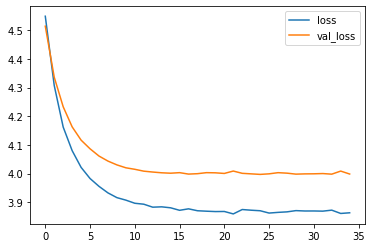

In [32]:
pd.DataFrame(history.history).plot()